# 미니 프로젝트

> 강의에서 다루었던 세 가지 팩터 전략을 가지고 팩터 기반 역변동성 포트폴리오 구현하기

> 세 가지 팩터 전략
- 주식 모멘텀
- 원자재 밸류
- 변동성 캐리

> 세 가지 팩터 전략을 기반으로 역변동성 팩터 포트폴리오 구현

### 1. 공통 패키지 설치 및 가격 데이터 로드

In [1]:
# pickle5 패키지 설치
!pip install pickle5 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# 패키지 임포트 : numpy, pandas, matplotlib, seaborn, scipy, pickle5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
sns.set()
import pickle5 as pickle

In [14]:
# 주식 가격 데이터 로드
with open('equity_price.pkl', 'rb') as f:
    price = pickle.load(f)
# 원자재 가격 데이터 로드
with open('commodity_price.pkl', 'rb') as f:
    price = pickle.load(f)

# CFTC Hedge 롱포지션 로드
with open('long_pos.pkl', 'rb') as f:
    long_pos = pickle.load(f)

# CFTC Hedge 숏포지션 로드
with open('short_pos.pkl', 'rb') as f:
    short_pos = pickle.load(f)

# CFTC 전체 포지션 로드
with open('total_pos.pkl', 'rb') as f:
    total_pos = pickle.load(f)

# VIX 데이터 로드 로드
with open('vol_price.pkl', 'rb') as f:
    df = pickle.load(f)

# VIX 선물 가격 데이터 로드
price = df.iloc[:, 0]

# VIX 기간구조 기울기 데이터 로드
slope = df.iloc[:, 1]


### 2. 주식 모멘텀 전략 구현

- 주식 모멘텀 클래스 제작
- 주식 모멘텀 클래스를 기반으로 백테스팅 수행

In [9]:
# 주식 모멘텀 클래스
class EquityMomentum:
    # 초기화 함수
    def __init__(self, price, lookback_period, n_selection, cost=0.0005, signal_method='dm', long_only=False):

        # 수익률
        self.rets = price.pct_change().fillna(0)

        # 모멘텀 방식 선택
        if signal_method == 'am':
            self.signal = self.absolute_momentum(price, lookback_period, long_only)
        elif signal_method == 'rm':
            self.signal = self.relative_momentum(price, lookback_period, n_selection, long_only)
        elif signal_method == 'dm':
            self.signal = self.dual_momentum(price, lookback_period, n_selection, long_only)

        # 거래비용
        self.cost = cost

        # 포트폴리오 수익률
        self.port_rets = self.calculate_returns(self.rets, self.signal, self.cost)

        # 샤프비율
        self.sharpe_ratio = self.calculate_sharpe_ratio(self.port_rets)

        # 백테스팅 결과
        self.plot_result(self.port_rets)

    # 절대 수익률 시그널 계산 함수
    def absolute_momentum(self, price, lookback, long_only=False):

        # N일 수익률
        returns = price.pct_change(periods=lookback)

        # 롱 시그널
        long_signal = (returns > 0) * 1

        # 숏 시그널
        short_signal = (returns < 0) * -1

        # 토탈 시그널
        if long_only:
            signal = long_signal
        else:
            signal = long_signal + short_signal

        return signal

    # 상대 모멘텀 시그널 계산 함수
    def relative_momentum(self, price, lookback, n_selection, long_only=False):

        # N일 수익률
        returns = price.pct_change(periods=lookback)

        # 수익률 순위화
        rank = returns.rank(axis=1, ascending=False)

        # 롱 시그널
        long_signal = (rank <= n_selection) * 1

        # 숏 시그널
        short_signal = (rank >= len(rank.columns) - n_selection + 1) * -1

        # 토탈 시그널
        if long_only:
            signal = long_signal
        else:
            signal = long_signal + short_signal

        return signal

    # 듀얼 모멘텀 시그널 계산 함수
    def dual_momentum(self, price, lookback, n_selection, long_only=False):

        # 절대 모멘텀 시그널
        abs_signal = self.absolute_momentum(price, lookback, long_only)

        # 상대 모멘텀 시그널
        rel_signal = self.relative_momentum(price, lookback, n_selection, long_only)

        # 듀얼 모멘텀 시그널
        signal = (abs_signal == rel_signal) * abs_signal

        return signal

    # 포트폴리오 수익률 계산 함수
    def calculate_returns(self, rets, signals, cost):

        # 포트폴리오 수익률
        port_rets = signals.shift() * rets - abs(signals.diff()) * cost

        return port_rets.mean(axis=1)

    # 샤프비율 계산
    def calculate_sharpe_ratio(self, total_returns):
        sharpe_ratio = total_returns.mean() * np.sqrt(252) / total_returns.std()

        return sharpe_ratio

    # 백테스팅 결과 시각화 함수
    def plot_result(self, rets):

        # 백테스팅 결과 시각화
        plt.figure(figsize=(12, 6))
        rets.cumsum().plot()
        plt.show()


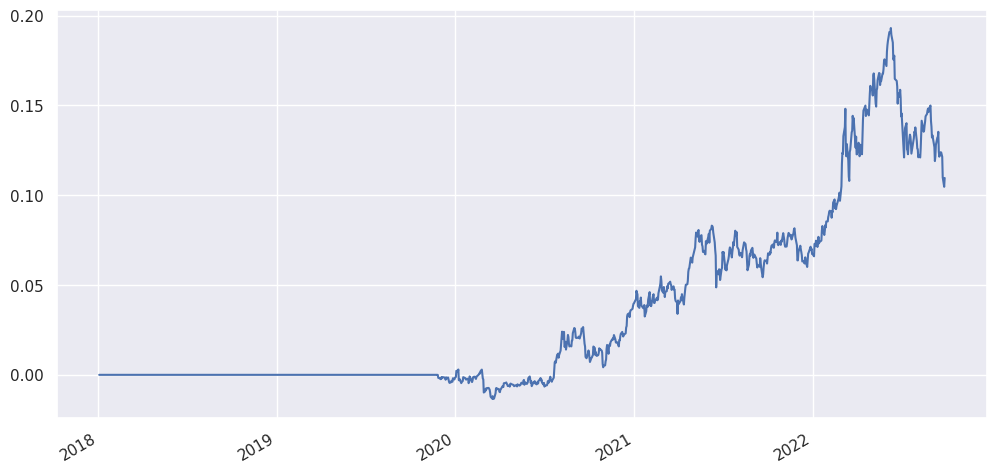

In [10]:
# 룩백 윈도우 = 24개월 (1개월은 20일)
lookback = 20 * 24

# 상대 모멘텀 롱숏 개수 = 전체의 1/4
n_selection = len(price.columns) / 4

# 주식 모멘텀 백테스팅
momentum = EquityMomentum(price, lookback, n_selection, long_only=True)

# 주식 모멘텀 팩터 수익률
momentum.sharpe_ratio

# equity_momentum_returns 인덱스를 pandas datetime 형태로 변환
momentum.port_rets.index = pd.to_datetime(momentum.port_rets.index)


### 3. 원자재 밸류 전략 구현

- 원자재 밸류 클래스 제작
- 원자재 밸류 클래스를 기반으로 백테스팅 수행

In [12]:
# 원자재 밸류 팩터 전략 구현 클래스
class CommodityValue:
    # 초기화 함수
    def __init__(self, price, long_pos, short_pos, total_pos):

        # 가격 데이터
        self.price = price

        # 포지션 데이터
        # CFTC Hedger 롱포지션
        self.long_pos = long_pos

        # CFTC Hedger 숏포지션
        self.short_pos = short_pos

        # CFTC 전체포지션
        self.total_pos = total_pos

        # 롱숏 개수
        self.n = int(len(self.price.columns) / 2)

        # 룩백 윈도우
        self.lookback = 52

        # 투자 가중치
        self.weights = self.calculate_weights(self.long_pos, self.short_pos, self.total_pos, self.lookback)

        # 거래비용
        self.cost = 0.0005

        # 포트폴리오 자산별 수익률
        self.port_rets = self.calculate_returns(self.price, self.weights, self.cost)
        self.port_rets.dropna(inplace=True)

        # 샤프비율
        self.sharpe_ratio = self.calculate_sharpe_ratio(self.port_rets)

        # 포트폴리오 백테스팅 결과 시각화
        self.plot_port_returns(self.port_rets)

    # 투자 가중치 계산 함수
    def calculate_weights(self, long_pos, short_pos, total_pos, lookback=52):

        # 롱숏 헤징 레인지
        long_hedging = long_pos / total_pos
        short_hedging = short_pos / total_pos

        long_hedging_range = (long_hedging - long_hedging.rolling(lookback).min()) / (long_hedging.rolling(lookback).max() - long_hedging.rolling(lookback).min())
        short_hedging_range = (short_hedging - short_hedging.rolling(lookback).min()) / (short_hedging.rolling(lookback).max() - short_hedging.rolling(lookback).min())

        # 롱숏 랭크
        long_rank = long_hedging_range.rank(axis=1)
        short_rank = short_hedging_range.rank(axis=1)

        # 투자 가중치
        long_weights = (long_rank > self.n) * (1/self.n)
        short_weights = (short_rank > self.n) * -(1/self.n)
        total_weights = long_weights + short_weights

        return total_weights

    # 수익률 계산
    def calculate_returns(self, price, weights, cost):

        # 일별 수익률
        rets = price.pct_change()

        # 가중치
        weights = weights.reindex_like(price)
        weights.ffill(inplace=True)

        # 포트폴리오 수익률
        port_rets = (weights.shift() * rets - abs(weights.diff()) * cost)

        return port_rets.sum(axis=1)

    # 샤프비율 계산
    def calculate_sharpe_ratio(self, total_returns):
        sharpe_ratio = total_returns.mean() * np.sqrt(252) / total_returns.std()
        return sharpe_ratio

    # 백테스팅 결과 시각화
    def plot_port_returns(self, rets):
        plt.figure(figsize=(12, 6))
        rets.cumsum().plot(label='port')
        plt.show()

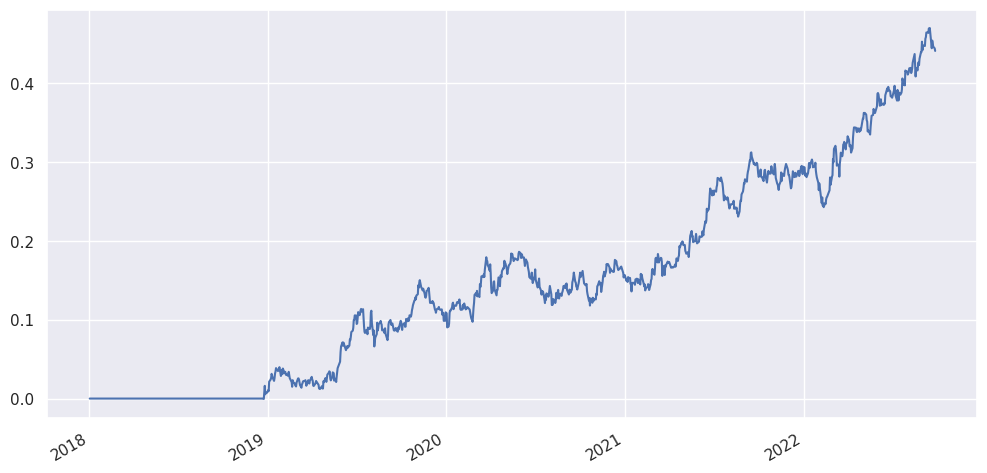

In [13]:
# 원자재 밸류 전략 백테스팅 실행
value = CommodityValue(price, long_pos, short_pos, total_pos)

# 원자재 밸류 전략 수익률
value.sharpe_ratio

# commodity_value_returns 인덱스를 pandas datetime 형태로 변환
value.port_rets.index = pd.to_datetime(value.port_rets.index)

### 4. 변동성 캐리 전략 구현

- 변동성 캐리 클래스 제작
- 변동성 캐리 클래스를 기반으로 백테스팅 수행

In [15]:
# 변동성 캐리 전략 구현 클래스
class VolatilityCarry:

    # 초기화 함수
    def __init__(self, price, slope):

        # 변동성 선물 가격
        self.price = price

        # 수익률
        self.rets = self.price.pct_change()

        # 기간구조 기울기
        self.slope = slope

        # 거래비용
        self.cost = 0.002

        # 가중치
        self.weights = self.calculate_weights(self.slope)

        # 포트폴리오 수익률
        self.port_rets = self.calculate_returns(self.rets, self.weights, self.cost)

        # 백테스팅 결과 시각화
        self.plot_port_returns(self.port_rets)

        # 샤프비율
        self.sharpe_ratio = self.calculate_sharpe_ratio(self.port_rets)

    # 가중치 계산 함수
    def calculate_weights(self, slope):

        # 롱 포지션
        long_weights = (slope < 1) * 1

        # 숏 포지션
        short_weights = (slope > 1) * -1

        # 토탈 포지션
        total_weights = long_weights + short_weights

        return total_weights


    # 포트폴리오 수익률 계산
    def calculate_returns(self, rets, weights, cost):
        port_rets = weights.shift() * rets - abs(weights.diff()) * cost

        return port_rets


    # 샤프비율 계산
    def calculate_sharpe_ratio(self, total_returns):
        sharpe_ratio = total_returns.mean() * np.sqrt(252) / total_returns.std()
        return sharpe_ratio

    # 백테스팅 결과 시각화
    def plot_port_returns(self, rets):
        plt.figure(figsize=(12, 6))
        rets.cumsum().plot(label='port')
        plt.show()

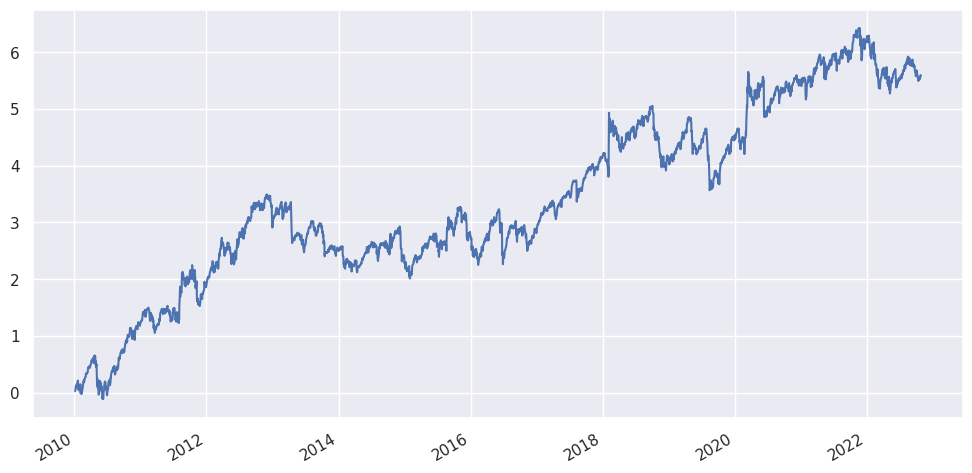

In [16]:
# 변동성 캐리 전략 백테스팅 수행
carry = VolatilityCarry(price, slope)

# 변동성 캐리 전략 수익률
carry.sharpe_ratio

# volatility_carry_returns의 인덱스를 pandas datetime 형태로 변환
carry.port_rets.index = pd.to_datetime(carry.port_rets.index)

### 5. 팩터 기반 역변동성 포트폴리오 백테스팅 구현

In [18]:
# EMV 포트폴리오 가중치 계산 함수
def calculate_emv_weights(aggregated_rets):
    weights_df = pd.DataFrame(index=aggregated_rets.index, columns=aggregated_rets.columns)

    for date, row in aggregated_rets.iterrows():
        inv_vol = 1 / row.std()
        weights_df.loc[date] = inv_vol / inv_vol.sum()

    return weights_df

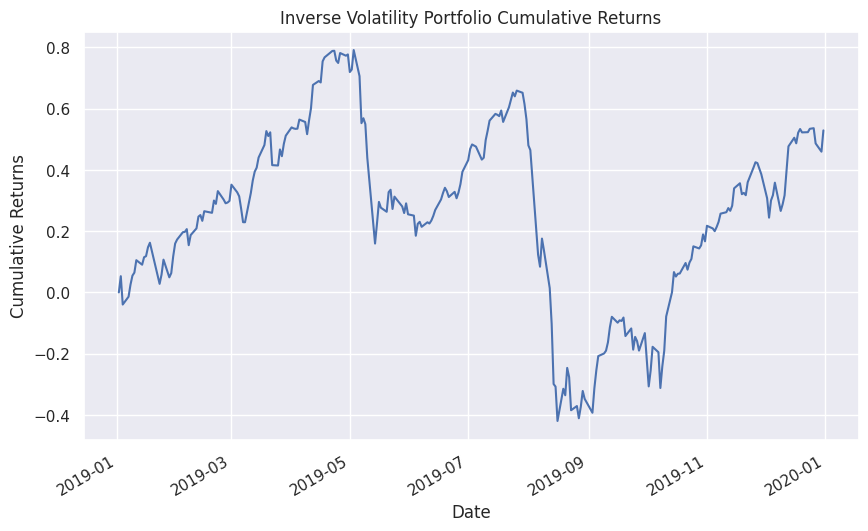

Inverse Volatility Portfolio Sharpe Ratio: 0.6521259750422489


In [21]:
# 세 전략의 수익률 데이터 취합 (전략들의 기간이 겹치는 구간만 추출, hint: pd.concat)
aggregated_rets = pd.concat([momentum.port_rets, value.port_rets, carry.port_rets], axis=1, join='inner').dropna()

# 2019년부터의 데이터만 추출
if not isinstance(aggregated_rets.index, pd.DatetimeIndex):
    aggregated_rets.index = pd.to_datetime(aggregated_rets.index)
aggregated_rets_2019 = aggregated_rets.loc['2019']

# 빈 데이터프레임 생성
weights_df = pd.DataFrame(index=aggregated_rets_2019.index, columns=aggregated_rets_2019.columns)

# 팩터간 공분산행렬의 3차원 배열 생성
# 주의! 일별 수익률에 대한 공분산 행렬이므로 연율화 계수는 252
# 일별 EMV 가중치 산출 (일별 리밸런싱 가정, 포지션 조정에 대한 거래비용은 없다고 가정)
for date, row in aggregated_rets_2019.iterrows():
    inv_vol = 1 / row.std()
    weights_df.loc[date] = inv_vol / inv_vol.sum()

# 일별 EMV 포트폴리오 수익률
daily_emv_rets = (weights_df.shift() * aggregated_rets_2019).sum(axis=1)

# EMV 포트폴리오 누적 수익률
cumulative_emv_rets = daily_emv_rets.cumsum()

# 역변동성 포트폴리오 백테스팅 결과 그래프
plt.figure(figsize=(10, 6))
cumulative_emv_rets.plot()
plt.title('Inverse Volatility Portfolio Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()

# 역변동성 포트폴리오 샤프비율 계산 및 출력
sharpe_ratio = daily_emv_rets.mean() / daily_emv_rets.std() * np.sqrt(252)
print(f'Inverse Volatility Portfolio Sharpe Ratio: {sharpe_ratio}')